<a href="https://colab.research.google.com/github/eisbetterthanpi/vision/blob/main/selenium_house.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Pillow --upgrade
# !pip install pandas --upgrade


In [ ]:
# @title setup
# https://colab.research.google.com/github/kaliiiiiiiiii/Selenium-Profiles/blob/master/google-colab/selenium_profiles.ipynb

%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium

# Install xvfb
apt install -y xvfb

# Install Selenium-Profiles
pip uninstall -y selenium_profiles
pip install --no-cache-dir selenium_profiles>=2.2.6

# pip install https://github.com/kaliiiiiiiiii/Selenium-Profiles/archive/refs/heads/dev.zip # dev-branch

# install python packages
pip install google-colab-shell
pip install webdriver-manager
pip install Pyvirtualdisplay


In [ ]:
# @title service
# https://stackoverflow.com/questions/76428999/selenium-chrome-webdriver-stopped-working
# https://stackoverflow.com/questions/76409097/driver-webdriver-chrome-issues-with-a-selenium-approach-how-to-work-aro

!apt-get update
!apt-get install chromium chromium-driver
!pip3 install selenium

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

service = Service(executable_path="chromedriver")
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--blink-settings=imagesEnabled=false') # me
# options.add_experimental_option("prefs", {"profile.managed_default_content_settings.images": 2})
driver = webdriver.Chrome(service=service, options=options)

# url = "https://www.google.com/search?q=Semi-Detached+House+bungalow+modern+-plan+-interior+-illustration+-news+-model+-3D"
# driver.get(url)  # test fingerprint
# print(driver.title)


In [3]:
# @title scrape google
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time
import requests
import math
from PIL import Image
import matplotlib.pyplot as plt

# Semi-Detached House bungalow modern -plan -interior -illustration -news -model -3D
url="https://www.google.com/search?sxsrf=AB5stBjzK4Qjah_pvMXlxkPxv3P1VZb1nQ:1688463777227&q=Semi-Detached+House+bungalow+modern+-plan+-interior+-illustration+-news+-model+-3D&tbm=isch&sa=X&ved=2ahUKEwiWh6Hd4fT_AhUp1jgGHb3WCAkQ0pQJegQIChAB&biw=1286&bih=876&dpr=1"
# terrace modern design "properties" -youtube -plan -interior -illustration -news -model -3D
# url = "https://www.google.com/search?q=terrace+modern+design+%22properties%22+-youtube+-plan+-interior+-illustration+-news+-model+-3D&tbm=isch&safe=active&chips=q:terrace+modern+design+properties+-youtube+-plan+-interior+-illustration+-news+-model+-3d,online_chips:3bdrm+townhouse"
# terrace home modern design
# url = "https://www.google.com/search?sxsrf=AB5stBiZ6cUkUivPpaWz3iSX09llLBFmqg:1688459159623&q=terrace+home+modern+design&tbm=isch&sa=X&ved=&biw=1286&bih=876&dpr=1#imgrc=o-90EBgQu5d1eM"

driver.get(url)

reject = driver.find_elements(By.XPATH,"*//button[@aria-label='Reject all']")#[0]#.click()
if reject: reject[0].click()



In [4]:
# @title funcs

def new_driver():
    service = Service(executable_path="chromedriver")
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--blink-settings=imagesEnabled=false') # me
    # options.add_experimental_option("prefs", {"profile.managed_default_content_settings.images": 2})
    driver = webdriver.Chrome(service=service, options=options)
    return driver


def scroll_end(driver):
    end = driver.find_elements(By.XPATH,'''*//div[@data-endedmessage="Looks like you've reached the end"]''')[0]#.click()
    while end.get_attribute("data-status") != "3": # =5, =3 when reach end
        more = driver.find_elements(By.XPATH,"*//input[@value='Show more results']")[0]#.click()
        if more.is_displayed(): more.click()
        # height = driver.execute_script("return document.body.scrollHeight")
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);") # scroll down

# start = time.time()
# scroll_end(driver)
# end = time.time()
# print(end-start) # 23.4sec 11.77s 14.43s
# start=end


# getting img url by clicking in, not reliable
#     # try: img_src = driver.find_elements(By.XPATH,"*//img[@jsname='kn3ccd']")[0].get_attribute("src")
#     # except: continue
#     # img_src = driver.find_elements(By.XPATH,"*//a[@class='Du2c7e']")[0].get_attribute("href")
#     # img_src = driver.find_elements(By.XPATH,"*//a[@class='Du2c7e']/img")[0].get_attribute("src")
def click_all(driver):
    see_more=[]
    hits = driver.find_elements(By.XPATH,"*//a[@class='wXeWr islib nfEiy']")
    driver.execute_script("hits = document.getElementsByClassName('wXeWr islib nfEiy')")
    print(len(hits)) # 780
    # for i, x in enumerate(hits):
    for i in range(len(hits)):
        # hits[i].click()
        driver.execute_script("hits["+str(i)+"].click();")
        try:
            WebDriverWait(driver, 3).until(EC.presence_of_element_located((By.XPATH, "*//a[@aria-label='See more Related content']")))
            see_mor = driver.find_elements(By.XPATH,"*//a[@aria-label='See more Related content']")[0].get_attribute("href")
        except: see_mor="_"
        see_more.append(see_mor)
    return see_more
# start = time.time()
# see_more = click_all(driver)
# end = time.time()
# print(end-start) # [i]:894.96sec , js:820sec=13m40s 801.75s 725.8 , no images 661=11m1s 741.8
# start=end

from urllib.parse import unquote
import re

def get_imgurls(driver):
    pro=driver.page_source
    # pro=driver.execute_script("return document.documentElement.outerHTML")
    pro = unquote(pro)
    pro = pro.encode().decode('unicode-escape') # try to remove \\u00
    # print(len(pro)) # , 2617498, 2977434, 3468337 # 1389443
    pattern = r"(?<=href=\"/imgres\?imgurl=)(?:(?!&amp;).)*(?=&amp;)" # start with href="/imgres?imgurl= , no &amp; , end with &amp; # https://stackoverflow.com/a/3926546/13359815
    m = re.findall(pattern, pro)
    return m

# start = time.time()
# m = get_imgurls(driver)
# end = time.time()
# print(end-start)
# start=end


import time
def get_skip(id=0, tt=20, dx=20):
    now = int(time.time())
    cyc = tt*dx
    curr = now %(cyc)
    want = id*dx
    skp = (want-curr)%cyc
    return skp




In [ ]:
hits = driver.find_elements(By.XPATH,"*//a[@class='wXeWr islib nfEiy']")
print(len(hits))
# print(len(img_urls))


780


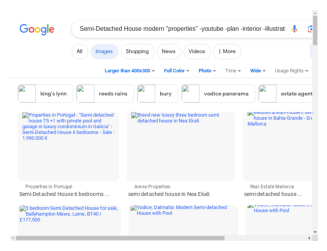

In [76]:
# @title check driver state
# from PIL import Image
# import matplotlib.pyplot as plt
driver.get_screenshot_as_file("canvas.png")
image = Image.open('canvas.png').convert("RGB")
plt.figure(figsize=(5, 3))
plt.axis('off')
plt.imshow(image)
plt.show()

# print(driver.page_source)


In [ ]:
# @title click images
# click in each image, way too slow
# driver.get(url)


img_urls=[]
# try: WebDriverWait(driver, 2).until(EC.presence_of_element_located((By.XPATH, "*//a[@class='wXeWr islib nfEiy']")))
# except: pass
hits = driver.find_elements(By.XPATH,"*//a[@class='wXeWr islib nfEiy']") # images
driver.execute_script("hits = document.getElementsByClassName('wXeWr islib nfEiy')")
print(len(hits))
# hits[0].click()
import time
start = time.time()
# driver.execute_script("arguments[0].click();"
for i, button in enumerate(hits):
    # hits[i].click()
    driver.execute_script("hits["+str(i)+"].click();")
    end = time.time()
    print(end-start)
    start=end

    # get img url from clicking
    try: img_src = driver.find_elements(By.XPATH,"*//img[@jsname='kn3ccd']")[0].get_attribute("src")
    except: continue
    # img_src = driver.find_elements(By.XPATH,"*//a[@class='Du2c7e']")[0].get_attribute("href")
    # img_src = driver.find_elements(By.XPATH,"*//a[@class='Du2c7e']/img")[0].get_attribute("src")
    print(i, img_src)
    img_urls.append(img_src)
    # if i>3: break
print("len(img_urls)", len(img_urls))


print("len(hits)", len(hits))





In [ ]:
# @title urls from page_source
# driver.get(url)

pro=driver.page_source
# pro=driver.execute_script("return document.documentElement.outerHTML")
# driver.page_sourceor driver.find_element(:tag_name => ‘body') .


from urllib.parse import unquote
pro = unquote(pro)
pro = pro.encode().decode('unicode-escape') # try to remove \\u00
# print(pro[2500000:])
# print(pro)
print(len(pro)) # , 2617498, 2977434, 3468337
# 1389443

import re
# pattern = r"https://(?:(?!\").)*\.jpg" # start with https:// , no " , end with .jpg # https://stackoverflow.com/a/67540659/13359815
pattern = r"(?<=href=\"/imgres\?imgurl=)(?:(?!&amp;).)*(?=&amp;)" # start with href="/imgres?imgurl= , no &amp; , end with &amp; # https://stackoverflow.com/a/3926546/13359815
# pattern = r"https://(?:(?!\").)*(?=\")" # start with https:// , no " , end with " # all urls
# pattern = r"(?<=\],\[\")https://(?:(?!\").)*(?=\")" # start with ],[" then https:// , no " , end with " # all imgs? fast

# print(pro.count("imgurl"))

m = re.findall(pattern, pro)
# print(m)
print(len(m)) # 73

# for i, x in enumerate(m):
#     print(i, x)


3423023
774


<ipython-input-13-01a18447da24>:11: DeprecationWarning: invalid escape sequence '\s'
  pro = pro.encode().decode('unicode-escape') # try to remove \\u00


In [ ]:
# @title check url
import requests
for i, x in enumerate(m):
    # print(x)
    response = requests.get(x)
    print(i, response.status_code == 200)
    # print(response=200)
    # print(response.json())
    # if response.json()['status'] != 'OK': return
    # lat, lng = response.json()['location'].values()
    # if i>3: break

# response = requests.get(x)
# # print(response.json())
# print(response)


# print(m)
# print(len(m))
# !pip install Pillow --upgrade
from PIL import Image
import requests
import matplotlib.pyplot as plt

for i in range(2,5):
    # print(m[i])
    response = requests.get(m[i], stream=True)
    # print(response)
    # print(response.raw)
    img = Image.open(response.raw)
    # try: img = Image.open(response.raw)
    # except: continue
    plt.imshow(img)
    plt.show()


## wwwwwwwww

In [ ]:
# https://stackoverflow.com/a/69881106/13359815
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

In [5]:
# @title setup pandas
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [47]:
# @title save to pandas

df_explore = pd.read_excel("/content/drive/MyDrive/explore_url.xlsx", engine='openpyxl') # central img and seemor
df_home = pd.read_excel("/content/drive/MyDrive/home_urls.xlsx", engine='openpyxl') # finalgood img urls
df_scrape = pd.read_excel("/content/drive/MyDrive/toscrape.xlsx", engine='openpyxl') # search urls to scrape

#  = pandas.concat([objs, ])

# import time
# start = time.time()


# df_all.to_excel('/content/drive/MyDrive/properties_batch.xlsx', index=False, header=False)




# display(df)
# img_seemor = [] # temp img url and seemor urls

# df_all = df_all[~df_all['api date'].isnull() &(df_all['bad']!=1)]
# df_all = df_all[df_all['Latitude']=='None']
# df_all = df_all[(df_all['bad']==1) & (df_all['blur']!=1)] # 3061
# print(len(df_all))
# print(len(df_all[df_all['Latitude']=='None']))
# Property Address Cleaned

# print(len(df_all[df_all['name'].isnull()]))
# df_all = df_all[df_all['name'].isnull()]

# print(list(df_all['Filename']))

# display(df_all.head())
# df_all


In [ ]:
# @title pandas row
import pandas as pd

# df = pd.DataFrame()
data = {'url':[], 'sm':[]}
df = pd.DataFrame(data)
# display(df)


for i, url in enumerate(m):
# for i, url in enumerate(m[:5]):
    if url in df['url'].values:
        # print(url, see_more[i])
        continue
    df.at[i, 'url'] = url
    df.at[i, 'sm'] = see_more[i]

# https://imgmy.waa2.com/home/160123/bungalow-for-sale-9a689ec9bd1db5caaea6d0343196e998_thumb.jpg

# print(df['url'].values)
display(df)



In [ ]:
# @title test append
import pandas as pd
import numpy as np

# data = {'url':[1,2,3], 'sm':[14,18,16]}
# df = pd.DataFrame(data)
# data = {'url':[7,4,7], 'sm':[24,28,26]}
# df1 = pd.DataFrame(data)

def reset_excel(): # reset excel
    df = pd.DataFrame()
    df.to_excel('/content/drive/MyDrive/explore_url.xlsx', header=None, index=None)


def appnd_excel():
    data = {'url':m, 'sm':see_more}
    df = pd.DataFrame(data)
    with pd.ExcelWriter('/content/drive/MyDrive/explore_url.xlsx', mode='a', engine="openpyxl", if_sheet_exists="overlay") as writer:
        # df.to_excel(writer, header=None, index=None, startrow=len(df.index))
        startrow = len(list(list(writer.sheets.values())[0].rows))
        df.to_excel(writer, header=None, index=None, startrow=startrow)

# display(df)

start = time.time()
print(len(df.index))

# reset_excel()
# while len(df.index)>0:
#     time.sleep(1)
#     df = pd.read_excel("/content/drive/MyDrive/explore_url.xlsx", engine='openpyxl')

appnd_excel()
while len(df.index)==0:
    time.sleep(1)
    df = pd.read_excel("/content/drive/MyDrive/explore_url.xlsx", engine='openpyxl')

print(len(df.index))

end = time.time()
print(end-start) # 23.4sec 11.77s 14.43s
start=end


0
778
1.5914013385772705


In [ ]:
# @title toscrape urls

# Semi-Detached House bungalow modern -plan -interior -illustration -news -model -3D
# Semi-Detached House bungalow modern -plan -interior -illustration -news -model -3D
# terrace modern design "properties" -youtube -plan -interior -illustration -news -model -3D
# terrace home modern design

# Semi-Detached House bungalow modern
# Semi-Detached House modern
# bungalow modern
# Detached House modern
# terrace modern design "properties"


a1=['Semi-Detached House', 'Detached House', 'terrace House', 'bungalow']
a2=['modern ', '']
a3=['''"properties" ''', '']

import itertools
a = itertools.product(a1, a2, a3)
for x in a:
    # print(x)
    # print(' '.join(x))
    search = ' '.join(x).replace('  ',' ')
    # search='''\
    # terrace modern design "properties"\
    # '''
    # print(search)
    exclude = "-youtube -plan -interior -illustration -news -model -3D"
    query = (search+exclude).replace(' ','+')
    # print(query)
    url = "https://www.google.com/search?as_st=y&tbm=isch&as_q="+query+"&as_epq=&as_oq=&as_eq=&cr=&as_sitesearch=&safe=active&tbs=isz:lt,islt:qsvga,itp:photo,ic:color,iar:w"
    print(url)


In [ ]:



# def img_mor(url)
def img_mor(url, id=0, tt=20, dx=20):
    try: driver.get(url)
    except: print(id, url)
    reject = driver.find_elements(By.XPATH,"*//button[@aria-label='Reject all']")#[0]#.click()
    if reject: reject[0].click()
    scroll_end(driver)
    see_more = click_all(driver)
    m = get_imgurls(driver)
    print(id, url, len(m), len(see_more))
    data = {'url':m, 'sm':see_more}
    df = pd.DataFrame(data)

    skip = get_skip(id=0, tt=20, dx=20)
    time.sleep(skip)

    with pd.ExcelWriter('/content/drive/MyDrive/explore_url.xlsx', mode='a', engine="openpyxl", if_sheet_exists="overlay") as writer:
        startrow = len(list(list(writer.sheets.values())[0].rows))
        df.to_excel(writer, header=None, index=None, startrow=startrow)
    return 'done!'


def get_search(sid=0, stt=4, sdx=20):
    skip = get_skip(id=sid, tt=stt, dx=sdx)
    time.sleep(skip)
    df_scrape = pd.read_excel("/content/drive/MyDrive/toscrape.xlsx", engine='openpyxl') # search urls to scrape
    tt_search = df_scrape['search_url'].count()
    done_idx = df_scrape['done'].count()
    print(done_idx, tt_search)
    df_scrape.loc[done_idx:min(done_idx+5-1, tt_search), 'done'] = 1
    df_scrape.to_excel('/content/drive/MyDrive/toscrape.xlsx', index=False)
    searchurls = df_scrape.loc[done_idx:min(done_idx+5-1, tt_search), 'search_url'].tolist()
    return searchurls



# for uuu in searchurls
# for c in range(0, len(searchurls), 5):

df_scrape = pd.read_excel("/content/drive/MyDrive/toscrape.xlsx", engine='openpyxl') # search urls to scrape
tt_search = df_scrape['search_url'].count()
done_idx = df_scrape['done'].count()

from concurrent.futures import ThreadPoolExecutor

while done_idx<tt_search:
    searchurls = get_search(sid=0)
    e = ThreadPoolExecutor(len(searchurls)) # sec
    future = [e.submit(img_mor, i, url) for i, url in enumerate(searchurls)]
    results = [f.result() for f in future]
    df_scrape = pd.read_excel("/content/drive/MyDrive/toscrape.xlsx", engine='openpyxl') # search urls to scrape
    tt_search = df_scrape['search_url'].count()
    done_idx = df_scrape['done'].count()

# e = ThreadPoolExecutor()
# i=0
# future = e.submit(delayed_square, i)
# result = future.result()
# print(result)


# display(df.drop_duplicates())

# if a['Names'].str.contains('Mel').any():
# mel_exists = (df['names'] == 'Mel').any()
# mel_exists2 = 'Mel' in df['names'].values



5 16
https://www.google.com/search?as_st=y&tbm=isch&as_q=Detached+House+modern+-youtube+-plan+-interior+-illustration+-news+-model+-3D&as_epq=&as_oq=&as_eq=&cr=&as_sitesearch=&safe=active&tbs=isz:lt,islt:qsvga,itp:photo,ic:color,iar:w 0
https://www.google.com/search?as_st=y&tbm=isch&as_q=Detached+House+"properties"+-youtube+-plan+-interior+-illustration+-news+-model+-3D&as_epq=&as_oq=&as_eq=&cr=&as_sitesearch=&safe=active&tbs=isz:lt,islt:qsvga,itp:photo,ic:color,iar:w 1
https://www.google.com/search?as_st=y&tbm=isch&as_q=Detached+House+-youtube+-plan+-interior+-illustration+-news+-model+-3D&as_epq=&as_oq=&as_eq=&cr=&as_sitesearch=&safe=active&tbs=isz:lt,islt:qsvga,itp:photo,ic:color,iar:w 2
https://www.google.com/search?as_st=y&tbm=isch&as_q=terrace+House+modern+"properties"+-youtube+-plan+-interior+-illustration+-news+-model+-3D&as_epq=&as_oq=&as_eq=&cr=&as_sitesearch=&safe=active&tbs=isz:lt,islt:qsvga,itp:photo,ic:color,iar:w 3
https://www.google.com/search?as_st=y&tbm=isch&as_q=terr

863
863
863
863


In [ ]:
searchurls = df_scrape.loc[0:5-1, 'search_url'].tolist()
# print(searchurls)
e = ThreadPoolExecutor(len(searchurls)) # sec
future = [e.submit(img_mor, i, url) for i, url in enumerate(searchurls)]
results = [f.result() for f in future]
df_scrape = pd.read_excel("/content/drive/MyDrive/toscrape.xlsx", engine='openpyxl') # search urls to scrape
tt_search = df_scrape['search_url'].count()
done_idx = df_scrape['done'].count()


https://www.google.com/search?as_st=y&tbm=isch&as_q=Semi-Detached+House+modern+"properties"+-youtube+-plan+-interior+-illustration+-news+-model+-3D&as_epq=&as_oq=&as_eq=&cr=&as_sitesearch=&safe=active&tbs=isz:lt,islt:qsvga,itp:photo,ic:color,iar:w 0
https://www.google.com/search?as_st=y&tbm=isch&as_q=Semi-Detached+House+modern+-youtube+-plan+-interior+-illustration+-news+-model+-3D&as_epq=&as_oq=&as_eq=&cr=&as_sitesearch=&safe=active&tbs=isz:lt,islt:qsvga,itp:photo,ic:color,iar:w 1
https://www.google.com/search?as_st=y&tbm=isch&as_q=Semi-Detached+House+"properties"+-youtube+-plan+-interior+-illustration+-news+-model+-3D&as_epq=&as_oq=&as_eq=&cr=&as_sitesearch=&safe=active&tbs=isz:lt,islt:qsvga,itp:photo,ic:color,iar:w 2
https://www.google.com/search?as_st=y&tbm=isch&as_q=Semi-Detached+House+-youtube+-plan+-interior+-illustration+-news+-model+-3D&as_epq=&as_oq=&as_eq=&cr=&as_sitesearch=&safe=active&tbs=isz:lt,islt:qsvga,itp:photo,ic:color,iar:w 3
https://www.google.com/search?as_st=y&tb

In [ ]:
# @title xlxs operation
df_scrape = pd.read_excel("/content/drive/MyDrive/toscrape.xlsx", engine='openpyxl') # search urls to scrape
# print(df_scrape.columns)
# df_scrape.loc[:, 'done'] = None
# df_scrape.drop(columns=[2], inplace=True)
# df_scrape.drop(columns=2, inplace=True)
# df_scrape.drop([2],axis=1)
display(df_scrape)
df_scrape.to_excel('/content/drive/MyDrive/toscrape.xlsx', index=False)


In [95]:

# df_explore = pd.read_excel("/content/drive/MyDrive/explore_url.xlsx", engine='openpyxl') # urls to explore
# df_home = pd.read_excel("/content/drive/MyDrive/home_urls.xlsx", engine='openpyxl') # good img urls
# df_explore.to_excel('/content/drive/MyDrive/explore_url.xlsx', index=False, header=False)



In [ ]:
# import os
# os.mkdir("/content/ggmap_frombad")
# for x in range(1,7):
#     os.mkdir("/content/ggmap_frombad/0"+str(x))


## from clean

In [ ]:
# @title setup / model
# https://colab.research.google.com/github/openai/clip/blob/master/notebooks/Interacting_with_CLIP.ipynb
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

import numpy as np
import torch
# from pkg_resources import packaging
# print("Torch version:", torch.__version__)
import clip
# clip.available_models()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model, preprocess = clip.load("ViT-B/32") # preprocess: normalize intensity using dataset mean and sd then resize and center-crop to conform to the model expects.
# model.cuda().eval()
model.to(device).eval()
input_resolution = model.visual.input_resolution # 224
context_length = model.context_length # 77
vocab_size = model.vocab_size # 49408
# print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}") # 151,277,313
# clip.tokenize("Hello World!") # case-insensitive tokenizer, padded to become 77 tokens


In [ ]:
# @title test texts
images=[]
og_img=[]

# [76,]

c=90
for i in range(c,c+15):
    # response = requests.get(m[i], stream=True)
    try: response = requests.get(m[i], stream=True)
    except: continue
    # img = Image.open(response.raw)
    try: img = Image.open(response.raw)
    except: continue
    images.append(preprocess(img))
    og_img.append(img)

# texts=['an image of the exterior facade of a modern house','an image of the exterior facade of a house','the interior of a house','an image with text words','a collage']
texts=['a modern design house architecture','an image of the front exterior facade of a house','the interior of a house','a thumbnail containing english text/ words','a leaflet/ advertisement containing english text/ words','a collage']

# housing facade, house front

# interior of a
# facade of a modern house
# text/ words


# normalize images, tokenize text input, forward pass model to get image text features
image_input = torch.tensor(np.stack(images)).to(device)
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).to(device)
# text_tokens = clip.tokenize(texts).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

# Calculating cosine similarity: normalize features and calculate dot product of each pair.
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
# print(similarity)

count = len(texts)

import matplotlib.pyplot as plt
# plt.figure(figsize=(20, 14))
plt.figure(figsize=(30, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(og_img):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, len(og_img) - 0.5])
# plt.ylim([count + 0.5, -2])
plt.ylim([count - 0.5, -1.5]) # bottom, top margin
plt.show()
# plt.title("Cosine similarity between text and image features", size=20)


In [ ]:
# @title base get similarity

images=[]
og_img=[]

c=110
for i in range(c,c+10):
    img,label=data[i]
    images.append(preprocess(img))
    og_img.append(img)

texts=['a modern design house architecture','an image of the front exterior facade of a house','the interior of a house','a thumbnail containing english text/ words','a leaflet/ advertisement containing english text/ words','a collage']


# normalize images, tokenize text input, forward pass model to get image text features
image_input = torch.tensor(np.stack(images)).to(device)
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).to(device)


with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

# Calculating cosine similarity: normalize features and calculate dot product of each pair.
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
# similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

similarity = text_features @ image_features.T
print(similarity)

# blur 0.23



In [ ]:
# @title collect
# use clip to get similarity scores for all images
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

texts=['a modern design house architecture','an image of the front exterior facade of a house','the interior of a house','a thumbnail containing english text/ words','a leaflet/ advertisement containing english text/ words','a collage']

text_tokens = clip.tokenize(["This is " + desc for desc in texts]).to(device)
with torch.no_grad(): text_features = model.encode_text(text_tokens).float()
text_features /= text_features.norm(dim=-1, keepdim=True)


def get_img(uuu):
    for _ in range(3):
        try:
            response = requests.get(uuu, stream=True)
            image = Image.open(response.raw)
            image = preprocess(image)
            return uuu, image
        except: continue
    return

batch_size = 1024 # 16

from concurrent.futures import ThreadPoolExecutor

uall = []
sall = torch.empty(0, device=device)
# for i, uuu in enumerate(m[:5]):
# for i, uuu in enumerate(m):
for i in range(0, len(m), batch_size):
    # i=0
    print(i)
    start = time.time()
    # e = ThreadPoolExecutor(batch_size) # 19.788sec
    e = ThreadPoolExecutor(min(batch_size, len(m))) # 21sec

    # result = e.map(get_img, m[i*batch_size: min((i+1)*batch_size, len(m))])
    # # result = e.map(get_img, m)
    # result = list(filter(lambda item: item is not None, result))

    future = [e.submit(get_img, uuu) for uuu in m[i*batch_size: min((i+1)*batch_size, len(m))]]
    # result = [f.result() for f in future if f.result() is not None]
    ulst = [f.result()[0] for f in future if f.result() is not None]
    images = [f.result()[1] for f in future if f.result() is not None]
    imgidx = [i for i in range(len(future)) if future[i].result() is not None] # only use for indexing m

    end = time.time()
    print(end-start)
    start=end

    images = torch.tensor(np.stack(images)).to(device)
    print(images.shape)
    # img= preprocess(images).to(device).unsqueeze(0)
    with torch.no_grad():
        image_features = model.encode_image(images).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = text_features @ image_features.T
    # print(similarity.squeeze())

    uall.append(ulst)
    sall = torch.cat((sall, similarity.squeeze().T))

print(sall)
# 19.6s, 25.88s


In [ ]:
# @title filter
import torchvision
from torchvision import transforms

great, good, interior, word, collage, left = [],[],[],[],[],[]
great_s, good_s, interior_s, word_s, collage_s, left_s = [],[],[],[],[],[]

texts=['a modern design house architecture','an image of the front exterior facade of a house','the interior of a house','a thumbnail containing english text/ words','a leaflet/ advertisement containing english text/ words','a collage']

length = len(sall[0])

t=0
# for i, similarity in sall:
# for i, similarity in enumerate(sall):
for idx, similarity in enumerate(sall):
    # idx = imgidx[i]
    modern = similarity[0]
    house = similarity[1]
    inter = similarity[2]
    text = similarity[3]
    ad = similarity[4]
    colge = similarity[5]

    # print(i, similarity)
    # great, good, interior, word, collage, left

    if inter>=0.27:
        interior.append(idx)
        interior_s.append(similarity)
    elif text>=0.20 or ad>=0.20:
        word.append(idx)
        word_s.append(similarity)
    # elif colge>=0.22:
    #     collage.append(idx)
    #     collage_s.append(similarity)

    # elif house<0.23 or (length-2)*house-similarity[2:].sum()<0.01 or house-iter<0.01 or house-text<0.01 or house-ad<0.01 or house-colge<0.01:
    elif house<0.23 or (length-2)*house-similarity[2:].sum()<0.01:# or house-iter<0.01 or house-text<0.01 or house-ad<0.01 or house-colge<0.01:
        left.append(idx)
        # print((length-2)*house-similarity[2:].sum())
        left_s.append((length-2)*house-similarity[2:].sum())
        # left_s.append(similarity)
    elif modern>=0.27: # great
        great.append(idx)
        great_s.append(similarity)
    else: # good
        good.append(idx)
        good_s.append(similarity)
    # print(similarity[1:].sum()-similarity[0])
    # t+=1
    # if t >=5: break


# great, good, interior, word, collage, left

print("sall",len(sall))
print("great",len(great))
print("good",len(good))
print("interior",len(interior))
print("word",len(word))
print("collage",len(collage))
print("left",len(left))



sall 51
great 12
good 20
interior 1
word 11
collage 0
left 7


In [ ]:
# @title house main




# for img_file, blurrness in zip(img_file_list, blurrness_list):
# for x,filename in enumerate(left):
# for x,(location, filename) in enumerate(zip(location_list, filename_list)):
for x,(location, filename) in enumerate(zip(location_list[start:], filename_list[start:])):
# for x,(olat, olng, filename) in enumerate(zip(latitude_list[start:], longitude_list[start:], filename_list[start:])):
    # if x in [34,40,62]:
    #     continue
    print(x)

    try:
        i = df_all.index[df_all['Filename'] == filename][0]
    except: i = df_all.index[df_all['Filename'] == filename.replace('-','/').replace('_','/')][0]
    # print(i)
    # df_all.at[i, 'glat'] = olat
    # df_all.at[i, 'glng'] = olng
    df_all.at[i, 'gdate'] = date
    df_all.at[i, 'name'] = filename
    # print(loc)

    cls=filename.split('. ')[0]
    filename=filename.replace("/", "-")

    pic_dir = file_dir+'/'+cls+'/'+filename + ' ' + date + '.jpg'

    with open(pic_dir, 'wb') as pic_file:
        pic_file.write(pic_content)
    # image = Image.open(pic_dir).convert("RGB")
    # plt.figure(figsize=(5, 4))
    # plt.axis('off')
    # plt.imshow(image)
    # plt.show()

    # t+=1
    # if t >=5: break

df_all.to_excel('/content/drive/MyDrive/properties_batch.xlsx', index=False, header=False)

# No Street View imagery available here


In [ ]:
# @title display imgs
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 300

def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

import torchvision.transforms as transforms
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),])
def ind_img(idx):
    for t in range(3):
        try:
            response = requests.get(m[idx], stream=True) # for checking only
            # response = requests.get(ulst[idx], stream=True)
            image = Image.open(response.raw)
            image = transform(image)
            # print(idx, ulst[idx])
            return image
        except: continue
    print(idx, m[idx])
    # print(idx, ulst[idx])
    return


from concurrent.futures import ThreadPoolExecutor
def ind2img(indlst):
    e = ThreadPoolExecutor(len(indlst))
    # result = e.map(ind_img, indlst) # 8/2.7sec 7/2.5
    # result = list(filter(lambda item: item is not None, result))

    future = [e.submit(ind_img, ind) for ind in indlst] # 5/2.2sec 7/2.4
    result = [f.result() for f in future if f.result() is not None]
    # print(None in result)
    [print(x.shape) for x in result]
    print(np.stack(result).shape)
    images = torch.tensor(np.stack(result))#.to(device)
    return images


c=0
start = time.time()
import torchvision
# imshow(torchvision.utils.make_grid(ind2img(great[c:c+64])))
# imshow(torchvision.utils.make_grid(ind2img(list(range(len(ulst))))))
imshow(torchvision.utils.make_grid(ind2img(list(range(c*64,(c+1)*64)))))


# for c in range(11):
#     print(c)
#     imshow(torchvision.utils.make_grid(ind2img(list(range(c*64,(c+1)*64)))))




end = time.time()
print(end-start)
start=end




In [ ]:
# print(len(future))
# print(len(m))
# print(len(imgidx))
# print(imgidx)
# print(see_more)
# for i,x in enumerate(see_more):
#     print(i,x)


print(len(m)) # 776
print(len(list(set(m)))) # 688
print(len(see_more)) # 788
print(len(list(set(see_more)))) # 780

# dm=list(set(m))
# ds=list(set(see_more))

# for i in range(600,605):
#     print(i,dm[i])
#     print(ds[i])


776
688
788
780


In [ ]:

for i,x in enumerate(m):
    if x in m[i+1:]:
        print(i,x)
# http://images.egorealestate.com/Z640x480/S5/C2868/P23537088/Tphoto/IDc0256701-0000-0500-0000-000010f09544.JPG


In [ ]:
for x in [248,271]:
    print(ulst[x])


In [ ]:
def file2img(img_files):
    imgs=[]
    for img_file in img_files:
        image = Image.open(img_file).convert("RGB")
        image=transforms.ToTensor()(image)
        imgs.append(image)
    return imgs


# imshow(torchvision.utils.make_grid(file2img(good[c:c+64])))

imshow(torchvision.utils.make_grid(great[c:c+64]))
# imshow(torchvision.utils.make_grid(file2img(great[c:c+64])))
# imshow(torchvision.utils.make_grid(file2img(good[c:c+64])))
# imshow(torchvision.utils.make_grid(file2img(interior)))
# imshow(torchvision.utils.make_grid(file2img(word[c:c+64])))
# # imshow(torchvision.utils.make_grid(file2img(left[c:c+100]),nrow=10))
# imshow(torchvision.utils.make_grid(file2img(left[c:c+64])))


print(obscured[c:c+64])


['/content/gsv70k/01/01. 20 BUTTERFLY AVE 2022-03.jpg', '/content/gsv70k/01/01. 9 JLN LABU AYER 2019-05.jpg', '/content/gsv70k/01/01. 7 LUCKY CRES 2022-09.jpg', '/content/gsv70k/01/01. 1A GUILLEMARD RD 2022-04.jpg', '/content/gsv70k/01/01. 102 JLN KURAS 2019-08.jpg', '/content/gsv70k/01/01. 38 PEACH GDN 2022-10.jpg', '/content/gsv70k/01/01. 30 JLN ASAS 2022-11.jpg', '/content/gsv70k/01/01. 17 ELITE TER 2022-09.jpg', '/content/gsv70k/01/01. 8 HAIG AVE 2022-05.jpg', '/content/gsv70k/01/01. 22 LIMAU GDN 2022-09.jpg', '/content/gsv70k/01/01. 92A GUILLEMARD RD 2022-09.jpg', '/content/gsv70k/01/01. 94 BRANKSOME RD 2022-03.jpg', '/content/gsv70k/01/01. 4 FIDELIO ST 2023-01.jpg', '/content/gsv70k/01/01. 132 MARSHALL RD 2022-10.jpg', '/content/gsv70k/01/01. 54 LICHI AVE 2018-03.jpg', '/content/gsv70k/01/01. 17 NAROOMA RD 2022-09.jpg', '/content/gsv70k/01/01. 22A BRIGHTON AVE 2019-04.jpg', '/content/gsv70k/01/01. 24 ROBERTS LN 2022-10.jpg', '/content/gsv70k/01/01. 442 MACPHERSON RD 2022-03.jpg',

In [ ]:
for i,x in enumerate(left_s):
    print(i, x.item())